In [9]:
"""
Cálculo dos coeficientes de dispersão cromática (β2 = ∂²β/∂ω², β3 = ∂³β/∂ω³, etc) 
em um guia cilíndrico de SiO2 com raio 0.65 μm rodeado por ar ;
e cálculo do coeficiente não-linear: γ = k0 * n2 / A_eff.

Valores simulados no Comsol (Versão 6.3):
neff: Índice de refração efetivo ao longo do eixo principal do guia
A_eff: área efetiva de guiamento

Outros parâmetros:
λ: comprimento de onda (variável independente);
ω: frequência angular da luz (ω = c * λ / (2 π) );
k0: constante de propagação (k0 = c / ω = 2 π / λ);
β: constante de propagação efetiva (β = neff * k0);
n2: índice de refração não linear (†);
c: velocidade da luz no vácuo.

(†) (ver: AGRAWAL, G. P. (2001). Nonlinear Fiber Optics (3rd ed.))
"""

import pandas as pd
import numpy as np
from scipy.constants import c, pi as π
from sympy import lambdify, symbols, diff

from matplotlib import pyplot as plt

import gc # Coletor de lixo (garbage collector)

Códigos unicode dos símbolos usados:

> Letras gregas

- $\mu$ : 03BC $\quad$  $\beta$ : 03B2

- $\omega$ : 03C9 $\quad$  $\gamma$ : 03B3

- $\lambda$ : 03BB $\quad$  $\pi$ : 03C0

> Símbolos matemáticos

- $\partial$ : 2202 $\quad$ $\int$ : 222B

> Símbolo textual:

- $\dagger$ : 2020

Instrução: Aperte Ctrl + Shift + U, depois insira o código unicode e tecle Enter

In [2]:
# Configuração dos plots:
rc = {"font.family" : "serif",
      "mathtext.fontset" : "stix",
      "axes.labelsize": 8,
      "axes.titlesize": 10,
      "figure.figsize": (7.90354375*0.7, 2),
      "xtick.direction": 'in',
      "xtick.labelsize": 6,
      "ytick.direction": 'in',
      "ytick.labelsize": 6,
      "legend.fontsize": 10,
      "lines.linewidth": 1,
      "lines.markersize": 2,
      "grid.alpha": 0.7,
      "grid.linestyle": '--',
      "grid.linewidth": 0.5,
      "figure.dpi": 200,
      'svg.fonttype': 'none'}

plt.rcParams.update(rc)

# Configurando fonte}
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [6]:
# Leitura de dados
###############
# Dados com simulação no Comsol 6.3
simulação = pd.read_csv("data_diam650nm.csv", skiprows=4)

# Tirando % da primeira coluna (formato exportado de header do Comsol)
###############
# Dicionário com nome das colunas de simulação
colunas = dict(zip(simulação.columns,simulação.columns))

# Associando à primeira coluna o seu novo nome, removendo '%':
# separando a expressão no primeiro espaço e pegando o que vem depois.
colunas[simulação.columns[0]] = simulação.columns[0].split(' ', 1)[1]

# Renomeando coluna dos dados
simulação = simulação.rename(columns=colunas)

# Formatando números complexos para leitura do python
simulação = simulação.map(lambda x: complex(x.replace("i", "j")) if type(x)==str else x)

# Imprimindo 5 primeiras linhas
simulação.head()

,wav (m),Effective_mode_index (1),effective area
0,5.000000e-07,1.372421+0.000000j,2.547523e-13
1,5.050000e-07,1.370565+0.000000j,2.565377e-13
2,5.100000e-07,1.368708-0.000000j,2.583475e-13
3,5.150000e-07,1.366849-0.000000j,2.601823e-13
4,5.200000e-07,1.364988-0.000000j,2.620423e-13


In [57]:
# Índice de refração efetivo
neff = np.real(simulação["Effective_mode_index (1)"])
# Comprimento de onda
λ = simulação["wav (m)"]
# Constante de propagação efetiva
β = 2 * np.pi * neff /  λ
# frequência angular
ω = 2 * np.pi * c /  λ
# ω0: frequência angular do comprimento de onda central
ω0 = 2 * π * c / (800e-9) # Hz
# frequência angular deslocada por ω0: ω_d = ω - ω0
ω_d = ω - ω0

# Regressão
# β = β0 + β1 * (ω - ω0) + (β2 / 2) * (ω - ω0)² + β3/6 * (ω - ω0)³
# β = D + C * (ω - ω0) + B * (ω - ω0)² + A * (ω - ω0)³
coef = np.polyfit(ω_d, β, 10)
print(coef)
print("β0(800nm): ", coef[-1] * 1e-6, '1/μm')
print("β1(800nm): ", coef[-2] * 10**15, 'ps/km')
print("β2(800nm): ", coef[-3] * 2 * 10**27, 'ps²/km')
print("β3(800nm): ", coef[-4] * 6 * 10**39, 'ps³/km')


[-3.81037574e-148  1.57927448e-132 -1.14730727e-117 -5.80614371e-102
  2.05254357e-086 -4.05422328e-071  6.13155060e-056 -6.02724894e-041
  6.59316669e-027  5.24784894e-009  9.87010005e+006]
β0(800nm):  9.870100050674196 1/μm
β1(800nm):  5247848.939308142 ps/km
β2(800nm):  13.186333385954669 ps²/km
β3(800nm):  -0.36163493631680893 ps³/km


In [58]:
# Cálculo simbólico
# ############# 
# variável simbólica que representa a frequência angular deslocada
z = symbols('z')
# expansão de β em termos de z
β_sym = sum(coef * (z)**i for i, coef in enumerate(reversed(coef)))
print('β(z) = ', β_sym)
# derivadas simbólica
β1_sym = diff(β_sym, z)
β2_sym = diff(β_sym, z, 2)
β3_sym = diff(β_sym, z, 3)

print(r'∂β/∂ω = ', β1_sym)
print(r'∂²β/∂ω² = ', β2_sym)
print(r'∂³β/∂ω³ = ', β3_sym)
# vetorização da derivada
β1_sym = lambdify(z, β1_sym, 'numpy')
β2_sym = lambdify(z, β2_sym, 'numpy')
β3_sym = lambdify(z, β3_sym, 'numpy')

# avaliando a derivada
β1_aval = β1_sym(ω_d)
β2_aval = β2_sym(ω_d)
β3_aval = β3_sym(ω_d)


β(z) =  -3.81037573550837e-148*z**10 + 1.57927447903639e-132*z**9 - 1.1473072689264e-117*z**8 - 5.80614370628802e-102*z**7 + 2.05254357446319e-86*z**6 - 4.05422327552142e-71*z**5 + 6.13155059989549e-56*z**4 - 6.02724893861348e-41*z**3 + 6.59316669297733e-27*z**2 + 5.24784893930814e-9*z + 9870100.0506742
∂β/∂ω =  -3.81037573550837e-147*z**9 + 1.42134703113275e-131*z**8 - 9.17845815141117e-117*z**7 - 4.06430059440162e-101*z**6 + 1.23152614467791e-85*z**5 - 2.02711163776071e-70*z**4 + 2.4526202399582e-55*z**3 - 1.80817468158404e-40*z**2 + 1.31863333859547e-26*z + 5.24784893930814e-9
∂²β/∂ω² =  -3.42933816195753e-146*z**8 + 1.1370776249062e-130*z**7 - 6.42492070598782e-116*z**6 - 2.43858035664097e-100*z**5 + 6.15763072338958e-85*z**4 - 8.10844655104283e-70*z**3 + 7.35786071987459e-55*z**2 - 3.61634936316809e-40*z + 1.31863333859547e-26
∂³β/∂ω³ =  -2.74347052956602e-145*z**7 + 7.9595433743434e-130*z**6 - 3.85495242359269e-115*z**5 - 1.21929017832049e-99*z**4 + 2.46305228935583e-84*z**3 - 2.

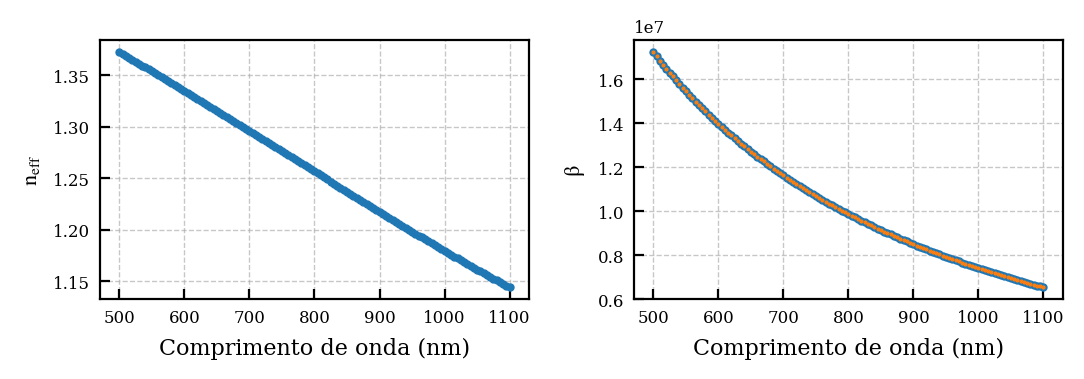

7792

In [63]:
plt.close("neff")
fig, ax = plt.subplots(1, 2, num = 'neff', figsize = (7.90354375*0.7,2), dpi = 200, clear = True)

ax[0].plot(λ*1e9, # x-axis 
         neff, # y-axis
         '.', # Marker style
           ms = 4 # Marker size
           )


ax[0].set_ylabel(r"$\mathrm{n_{eff}}$")

ax[1].plot(λ*1e9, # x-axis 
         β, # y-axis
         '.', # Marker style
           ms = 4 # Marker size
           )

ax[1].plot(λ*1e9, # x-axis 
         sum(_ * (ω_d)**i for i, _ in enumerate(reversed(coef))), # y-axis
         '.', # Marker style
           ms = 1 # Marker size
           )

ax[1].set_ylabel(r"$\mathrm{\beta}$")

for axes in ax.flat:
    axes.grid(True, which='both', linestyle='--', linewidth=0.5)
    axes.set_xlabel(r"Comprimento de onda (nm)")



plt.tight_layout()
plt.show()
gc.collect()


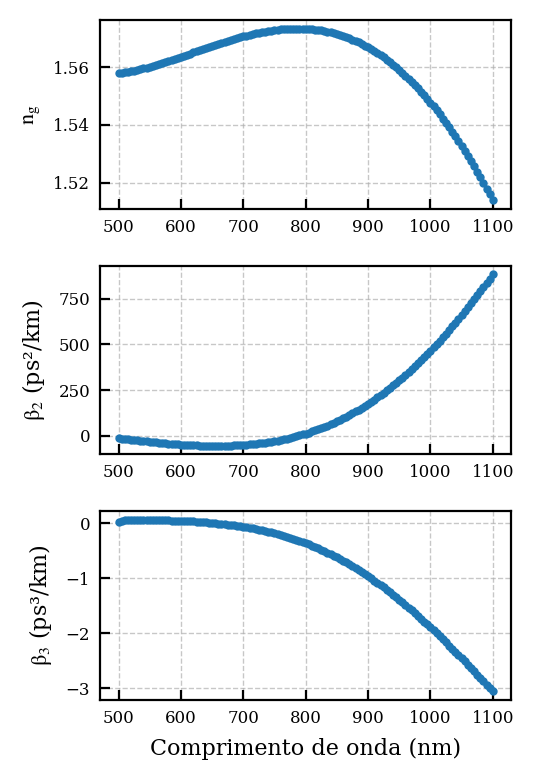

7647

In [60]:
plt.close("Índice de grupo")
fig, ax = plt.subplots(3, 1, num = 'Índice de grupo', figsize = (7.90354375/2*0.7,4), dpi = 200, clear = True)

ax[0].plot(λ*1e9, # x-axis
        c*β1_aval, # y-axis
        '.', # Marker style
        ms = 4 # Marker size
        )

ax[1].plot(λ*1e9, # x-axis
        β2_aval*10**27, # y-axis
        '.', # Marker style
        ms = 4 # Marker size
        )

ax[2].plot(λ*1e9, # x-axis
        β3_aval*λ/λ*10**39, # y-axis
        '.', # Marker style
        ms = 4 # Marker size
        )

ax[0].set_ylabel(r"$\mathrm{n_g}$")
ax[1].set_ylabel(r"$\mathrm{\beta_2}$ (ps²/km)")
ax[2].set_ylabel(r"$\mathrm{\beta_3}$ (ps³/km)")

ax[-1].set_xlabel(r"Comprimento de onda (nm)")

for axes in ax.flat:
    axes.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.show()
gc.collect()


In [30]:
# Calculando índice de grupo (ng) a partir do índice efetivo (neff)
###############
# ng == neff - λ * ∂ (neff) / ∂λ
# λ : comprimento de onda

# ∂ (neff) / ∂λ
# dn_dλ = np.diff(neff)/np.diff(λ)
dn_dλ = np.gradient(neff, λ)

# Índice de grupo
# ng = neff[:-1] - λ[:-1] * dn_dλ
ng = neff - λ * dn_dλ

# Calculando β2 e β3
###############
# β2 = - λ² / (2 π c²) * ∂ (ng) / ∂λ
# β2 = - λ[:-2]**2 / (2 * π * c**2) * np.diff(ng)/np.diff(λ[:-1]) # s²/m
β2 = - λ**2 / (2 * π * c**2) * np.gradient(ng, λ) # s²/m

# β3 =  - λ² / (2 π c²) * ∂ (β2) / ∂λ
# β3 = - λ[:-3]**2 / (2 * π * c**2) * np.diff(β2) / np.diff(λ[:-2]) # s³/m
β3 = - λ**2 / (2 * π * c**2) * np.gradient(β2, λ) # s³/m

# Imprimindo valores de β2 e β3 em 800 nm (comprimento de onda central do pulso Gaussiano);
# 800 nm: λ[i]
i = pd.Series(abs(λ-8e-7)).idxmin()

print(round(λ[i]*10**9, 3), 'nm') 
print(f"β0(800nm) = {2*np.pi*neff[i]/λ[i]*1e-6} 1/μm")
print(f"β1(800nm) = {ng[i]/c*10**15} ps/km")
print(f"β2(800nm) = {β2[i]*10**27} ps²/km")
print(f"β3(800nm) = {β3[i]*10**39} ps³/km")


800.0 nm
β0(800nm) = 9.870099884839522 1/μm
β1(800nm) = 5247839.963758113 ps/km
β2(800nm) = 13.243149896682226 ps²/km
β3(800nm) = -1.2081764922197461e-09 ps³/km


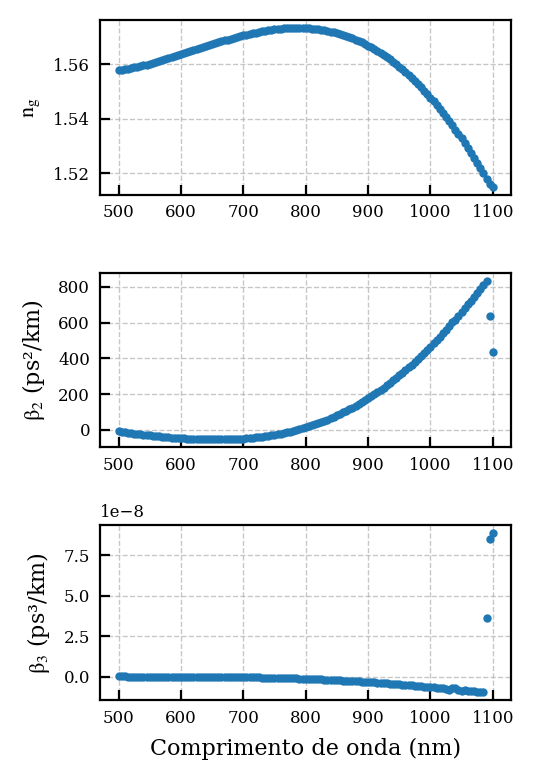

9578

In [48]:
plt.close("Índice de grupo")
fig, ax = plt.subplots(3, 1, num = 'Índice de grupo', figsize = (7.90354375/2*0.7,4), dpi = 200, clear = True)

ax[0].plot(λ*1e9, # x-axis
        ng, # y-axis
        '.', # Marker style
        ms = 4 # Marker size
        )

ax[1].plot(λ*1e9, # x-axis
        β2*10**27, # y-axis
        '.', # Marker style
        ms = 4 # Marker size
        )

ax[2].plot(λ*1e9, # x-axis
        β3*10**39, # y-axis
        '.', # Marker style
        ms = 4 # Marker size
        )

ax[0].set_ylabel(r"$\mathrm{n_g}$")
ax[1].set_ylabel(r"$\mathrm{\beta_2}$ (ps²/km)")
ax[2].set_ylabel(r"$\mathrm{\beta_3}$ (ps³/km)")

ax[-1].set_xlabel(r"Comprimento de onda (nm)")

for axes in ax.flat:
    axes.grid(True, which='both', linestyle='--', linewidth=0.5)

        
plt.tight_layout()
plt.show()
gc.collect()


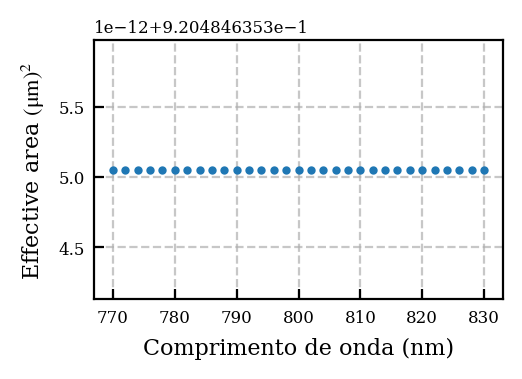

1904

In [ ]:
# Área efetiva (A_eff) calculada no Comsol
# A_eff = (∫ |E|² dS)²/(∫ |E|⁴ dS);
# dS: elemento de área transversal ao eixo principal do guia
# A integral é sobre toda a área simulada (modelo 2D)
###############
A_eff = simulação["A_eff (m^2)"]

plt.close("A_eff")
fig, ax = plt.subplots(num = 'A_eff', figsize = (7.90354375/2*0.7,2), dpi = 200, clear = True)

ax.plot(λ*1e9, 
        A_eff*10**12, 
        '.', # Marker style
        ms = 4 # Marker size
        )


ax.set_ylabel(r"Effective area $(\mathrm{\mu m})^2$")
ax.set_xlabel(r"Comprimento de onda (nm)")


ax.grid(True, which='both', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()
gc.collect()


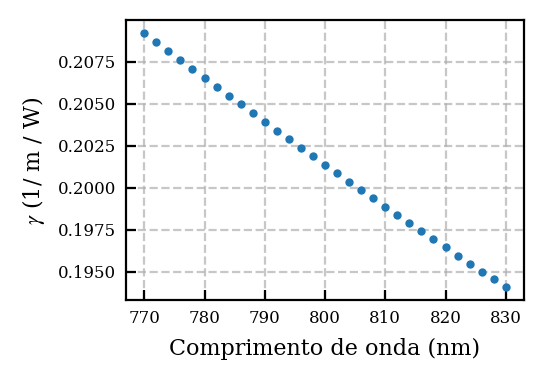

3608

In [44]:
# Cálculo do γ (gamma)
###############
n2  = 2.36 * 10**(-20) # m² / W

γ = (2 * np.pi / λ) * n2 / A_eff # 1 / m / W

plt.close("gamma")
fig, ax = plt.subplots(num = 'gamma', figsize = (7.90354375/2*0.7,2), dpi = 200, clear = True)

ax.plot(λ*1e9, # x-axis
        γ, # y-axis
        '.', # Marker style
        ms = 4 # Marker size
        )

ax.set_ylabel(r"$\gamma$ (1/ m / W) ")
ax.set_xlabel(r"Comprimento de onda (nm)")

ax.grid(True, which='both', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()
gc.collect()


In [62]:
print(f"γ(800nm) = {γ[15]} 1/m/W")


γ(800nm) = 0.2013656278926551 1/m/W
